In [1]:
import numpy as np
import tensorflow as tf

import sys
sys.path.append("..")

from models.regression_model import DemoRegressionDGP
from likelihoods import Gaussian
from utils_training import regression_train_demo

from matplotlib import pyplot as plt

2022-08-20 11:07:34.400246: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2022-08-20 11:07:35.604610: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2022-08-20 11:07:35.658626: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:25:00.0 name: NVIDIA RTX A5000 computeCapability: 8.6
coreClock: 1.695GHz coreCount: 64 deviceMemorySize: 23.69GiB deviceMemoryBandwidth: 715.34GiB/s
2022-08-20 11:07:35.658653: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2022-08-20 11:07:35.662111: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2022-08-20 11:07:35.662146: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.

In [2]:
def get_square_data(num_training, num_testing, std_noise=0.01):
    num_low = num_training // 2
    num_high = num_training - num_low
    X_train = np.vstack((np.linspace(-1.5, -0.5, num_low//2)[:, np.newaxis],
                         np.linspace(-0.45, 0.45, num_high)[:, np.newaxis], 
                         np.linspace(0.5, 1.5, num_low - num_low//2)[:, np.newaxis]))
    y = np.vstack((np.zeros((num_low//2, 1)), np.ones((num_high,1)),
                   np.zeros((num_low-num_low//2,1))))
    scale = np.sqrt(y.var())
    offset = y.mean()
    Y_train = (y-offset)/scale

    X_test = np.linspace(-3., 3., num_testing)[:, None]
    Y_test = []
    for x in X_test[:,0]:
        if x > -0.5 and x < 0.5:
            y = 1.
        else:
            y = 0.
        Y_test.append(y)
    Y_test = np.array(Y_test)[:, np.newaxis]
    Y_test = (Y_test - offset)/scale
    return np.float32(X_train), np.float32(Y_train), np.float32(X_test), np.float32(Y_test)

def load_demo_data(num_training, num_testing, batch_size, std_noise=0.01):
    X_train, Y_train, X_test, Y_test= get_square_data(num_training, num_testing, std_noise=std_noise)
    ds_X_train = tf.data.Dataset.from_tensor_slices(X_train)
    ds_Y_train = tf.data.Dataset.from_tensor_slices(Y_train)
    ds_train = tf.data.Dataset.zip((ds_X_train, ds_Y_train))
    ds_X_test = tf.data.Dataset.from_tensor_slices(X_test)
    ds_Y_test = tf.data.Dataset.from_tensor_slices(Y_test)
    ds_test = tf.data.Dataset.zip((ds_X_test, ds_Y_test))

    ds_train = ds_train.shuffle(num_training)
    # ds_test = ds_test.shuffle(num_testing)
    ds_train = ds_train.batch(batch_size) # try not to use full data as one batch
    ds_test = ds_test.batch(num_testing)
    return ds_train, ds_test, X_test

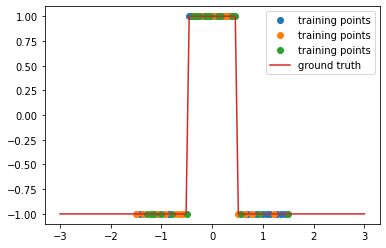

In [41]:
num_training = 60
batch_size = 20
num_testing = 100
std_noise = 0.1

ds_train, ds_test, X_test = load_demo_data(num_training, num_testing, batch_size, std_noise=std_noise)
for x, y in ds_train:
    plt.plot(x[:,0], y[:,0], 'o',linewidth=0.5, label='training points')
for x, y in ds_test:
    plt.plot(x[:,0], y[:,0], label='ground truth')
plt.legend()
# plt.savefig('square.png')

# 1-layer GPs (fixing kernel params)

In [4]:
# initialize the model
d_in = 1
d_out = 1
model = DemoRegressionDGP(d_in, d_out, n_hidden_layers=1, n_rf=300, n_gp=1,
                          likelihood=Gaussian(variance=0.01, trainable=False),
                          kernel_type_list=['RBF'], kernel_trainable=False,
                          random_fixed=True, input_cat=False)

In [5]:
model.kernel_list[0].length_scale

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.4142137], dtype=float32)>

In [6]:
model.kernel_list[0].amplitude

<tf.Tensor: shape=(), dtype=float32, numpy=0.5>

In [5]:
# training settings
lr_0 = 0.01
beta = 0.99
total_epochs = 2000
start_sampling_epoch = 0
epochs_per_cycle = 50
print_epoch_cycle = 50

In [6]:
_, _, lines, W = regression_train_demo(model, ds_train, ds_test, num_training, batch_size, X_test,
                                                              lr_0=lr_0, momentum_decay=beta,
                                                              resample_in_cycle_head=False, total_epochs=total_epochs,
                                                              start_sampling_epoch=start_sampling_epoch,
                                                              epochs_per_cycle=epochs_per_cycle,
                                                              print_epoch_cycle=print_epoch_cycle)

2022-08-20 08:26:04.908282: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
2022-08-20 08:26:04.928324: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2022-08-20 08:26:05.526450: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2022-08-20 08:26:05.526561: I tensorflow/stream_executor/cuda/cuda_blas.cc:1838] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


#################### Sampling at Epoch 49  lr = 1.2021529605110715e-10 ####################
Epoch: 49
Mean Log Likelihood -- train: -19.41837501525879, -- test: -66.80551147460938 
Root Mean Squared Error -- train: 0.6450119614601135, -- test: 1.1678111553192139 
 
#################### Sampling at Epoch 99  lr = 1.2021529605110715e-10 ####################
Epoch: 99
Mean Log Likelihood -- train: -9.708231925964355, -- test: -248.1070556640625 
Root Mean Squared Error -- train: 0.47099635004997253, -- test: 2.2337892055511475 
 
#################### Sampling at Epoch 149  lr = 1.2021529605110715e-10 ####################
Epoch: 149
Mean Log Likelihood -- train: -7.464330196380615, -- test: -149.24615478515625 
Root Mean Squared Error -- train: 0.42066556215286255, -- test: 1.7356832027435303 
 
#################### Sampling at Epoch 199  lr = 1.2021529605110715e-10 ####################
Epoch: 199
Mean Log Likelihood -- train: -7.77556037902832, -- test: -122.47209930419922 
Root Mean Squa

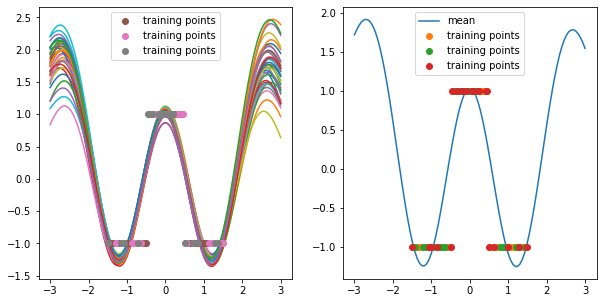

In [7]:
# print sampled lines
fig, ax = plt.subplots(1, model.n_hidden_layers+1, figsize=((model.n_hidden_layers+1)*5, 5))
ax = ax.flatten()
for i in range(model.n_hidden_layers):
    for model_line in lines[5:]: # hidden outputs of each sampled model
        line = model_line[i]
        ax[i].plot(X_test[:,0], line.numpy()[:,0])
    # for model_line in lines[690:701]: # hidden outputs of each sampled model
    #     line = model_line[i]
    #     ax[i].plot(X_test.numpy()[:,0], line.numpy()[:,0], 'b')
for x, y in ds_train:
    ax[-2].plot(x[:,0], y[:,0], 'o', label='training points')
# for x, y in ds_test:
    # ax[-1].plot(x[:,0], y[:,0], '*', label='ground truth')
ax[-2].legend()

# compute the mean of the sampled lines
line_output = []
for model_line in lines[5:]:
    line_output.append(model_line[-1]) #the final layer
line_mean = tf.reduce_mean(tf.concat(line_output, axis=-1), axis=-1)
ax[-1].plot(X_test[:,0], line_mean.numpy(), label='mean')
for x, y in ds_train:
    ax[-1].plot(x[:,0], y[:,0], 'o', label='training points')
ax[-1].legend()

# 2-layer DGPs (fixing kernel params)

In [4]:
# initialize the model
d_in = 1
d_out = 1
model = DemoRegressionDGP(d_in, d_out, n_hidden_layers=2, n_rf=100, n_gp=1,
                          likelihood=Gaussian(variance=0.01, trainable=False),
                          kernel_type_list=['RBF' for i in range(2)], kernel_trainable=False,
                          random_fixed=True, input_cat=False)

In [5]:
model.kernel_list[0].length_scale

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>

In [6]:
model.kernel_list[0].amplitude

<tf.Tensor: shape=(), dtype=float32, numpy=0.5>

In [7]:
# training settings
lr_0 = 0.02
beta = 0.
total_epochs = 100000
start_sampling_epoch = 0
epochs_per_cycle = 50
print_epoch_cycle = 50

In [8]:
_, _, lines, W = regression_train_demo(model, ds_train, ds_test, num_training, batch_size, X_test,
                                                              lr_0=lr_0, momentum_decay=beta,
                                                              resample_in_cycle_head=False, total_epochs=total_epochs,
                                                              start_sampling_epoch=start_sampling_epoch,
                                                              epochs_per_cycle=epochs_per_cycle,
                                                              print_epoch_cycle=print_epoch_cycle)

2022-08-20 11:08:17.205677: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
2022-08-20 11:08:17.223249: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2022-08-20 11:08:17.853445: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2022-08-20 11:08:17.853520: I tensorflow/stream_executor/cuda/cuda_blas.cc:1838] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


#################### Sampling at Epoch 49  lr = 2.404305921022143e-10 ####################
Epoch: 49
Mean Log Likelihood -- train: -6.2812275886535645, -- test: -50.384490966796875 
Root Mean Squared Error -- train: 0.39153221249580383, -- test: 1.01752769947052 
 
#################### Sampling at Epoch 99  lr = 2.404305921022143e-10 ####################
Epoch: 99
Mean Log Likelihood -- train: -6.182208061218262, -- test: -46.8999137878418 
Root Mean Squared Error -- train: 0.388994961977005, -- test: 0.9826856851577759 
 
#################### Sampling at Epoch 149  lr = 2.404305921022143e-10 ####################
Epoch: 149
Mean Log Likelihood -- train: -6.187300682067871, -- test: -50.227108001708984 
Root Mean Squared Error -- train: 0.38912585377693176, -- test: 1.0159798860549927 
 
#################### Sampling at Epoch 199  lr = 2.404305921022143e-10 ####################
Epoch: 199
Mean Log Likelihood -- train: -6.2272868156433105, -- test: -50.600685119628906 
Root Mean Squared 

2022-08-20 11:17:13.013965: W tensorflow/core/kernels/data/model_dataset_op.cc:205] Optimization loop failed: Cancelled: Operation was cancelled


#################### Sampling at Epoch 16899  lr = 2.404305921022143e-10 ####################
Epoch: 16899
Mean Log Likelihood -- train: -5.0889506340026855, -- test: -21.28748321533203 
Root Mean Squared Error -- train: 0.3597942888736725, -- test: 0.6733666062355042 
 
#################### Sampling at Epoch 16949  lr = 2.404305921022143e-10 ####################
Epoch: 16949
Mean Log Likelihood -- train: -5.057218551635742, -- test: -22.898420333862305 
Root Mean Squared Error -- train: 0.35891127586364746, -- test: 0.6968796849250793 
 
#################### Sampling at Epoch 16999  lr = 2.404305921022143e-10 ####################
Epoch: 16999
Mean Log Likelihood -- train: -5.0142822265625, -- test: -23.40601348876953 
Root Mean Squared Error -- train: 0.3577129542827606, -- test: 0.7041258215904236 
 
#################### Sampling at Epoch 17049  lr = 2.404305921022143e-10 ####################
Epoch: 17049
Mean Log Likelihood -- train: -5.03955078125, -- test: -23.342330932617188 
Roo

2022-08-20 11:32:39.112169: W tensorflow/core/kernels/data/model_dataset_op.cc:205] Optimization loop failed: Cancelled: Operation was cancelled


#################### Sampling at Epoch 45749  lr = 2.404305921022143e-10 ####################
Epoch: 45749
Mean Log Likelihood -- train: -2.5448145866394043, -- test: -64.65258026123047 
Root Mean Squared Error -- train: 0.2803020179271698, -- test: 1.1492277383804321 
 
#################### Sampling at Epoch 45799  lr = 2.404305921022143e-10 ####################
Epoch: 45799
Mean Log Likelihood -- train: -2.4423208236694336, -- test: -70.07951354980469 
Root Mean Squared Error -- train: 0.2766213119029999, -- test: 1.195517897605896 
 
#################### Sampling at Epoch 45849  lr = 2.404305921022143e-10 ####################
Epoch: 45849
Mean Log Likelihood -- train: -2.4355359077453613, -- test: -66.04693603515625 
Root Mean Squared Error -- train: 0.2763758897781372, -- test: 1.16129732131958 
 
#################### Sampling at Epoch 45899  lr = 2.404305921022143e-10 ####################
Epoch: 45899
Mean Log Likelihood -- train: -2.505213499069214, -- test: -66.07926940917969 
R

2022-08-20 11:43:36.677706: W tensorflow/core/kernels/data/model_dataset_op.cc:205] Optimization loop failed: Cancelled: Operation was cancelled


#################### Sampling at Epoch 66099  lr = 2.404305921022143e-10 ####################
Epoch: 66099
Mean Log Likelihood -- train: -2.4571874141693115, -- test: -60.128074645996094 
Root Mean Squared Error -- train: 0.2771582007408142, -- test: 1.1091593503952026 
 
#################### Sampling at Epoch 66149  lr = 2.404305921022143e-10 ####################
Epoch: 66149
Mean Log Likelihood -- train: -2.464543104171753, -- test: -57.77714538574219 
Root Mean Squared Error -- train: 0.2774234712123871, -- test: 1.0877572298049927 
 
#################### Sampling at Epoch 66199  lr = 2.404305921022143e-10 ####################
Epoch: 66199
Mean Log Likelihood -- train: -2.47216796875, -- test: -57.68256378173828 
Root Mean Squared Error -- train: 0.27769818902015686, -- test: 1.0868873596191406 
 
#################### Sampling at Epoch 66249  lr = 2.404305921022143e-10 ####################
Epoch: 66249
Mean Log Likelihood -- train: -2.521000385284424, -- test: -60.12822341918945 
Ro

2022-08-20 11:49:26.549596: W tensorflow/core/kernels/data/model_dataset_op.cc:205] Optimization loop failed: Cancelled: Operation was cancelled


#################### Sampling at Epoch 76749  lr = 2.404305921022143e-10 ####################
Epoch: 76749
Mean Log Likelihood -- train: -2.418269395828247, -- test: -70.49406433105469 
Root Mean Squared Error -- train: 0.27575045824050903, -- test: 1.1989805698394775 
 
#################### Sampling at Epoch 76799  lr = 2.404305921022143e-10 ####################
Epoch: 76799
Mean Log Likelihood -- train: -2.4264259338378906, -- test: -72.76100158691406 
Root Mean Squared Error -- train: 0.27604609727859497, -- test: 1.2177408933639526 
 
#################### Sampling at Epoch 76849  lr = 2.404305921022143e-10 ####################
Epoch: 76849
Mean Log Likelihood -- train: -2.4770123958587646, -- test: -69.83843994140625 
Root Mean Squared Error -- train: 0.27787259221076965, -- test: 1.1934996843338013 
 
#################### Sampling at Epoch 76899  lr = 2.404305921022143e-10 ####################
Epoch: 76899
Mean Log Likelihood -- train: -2.3768181800842285, -- test: -70.14955139160

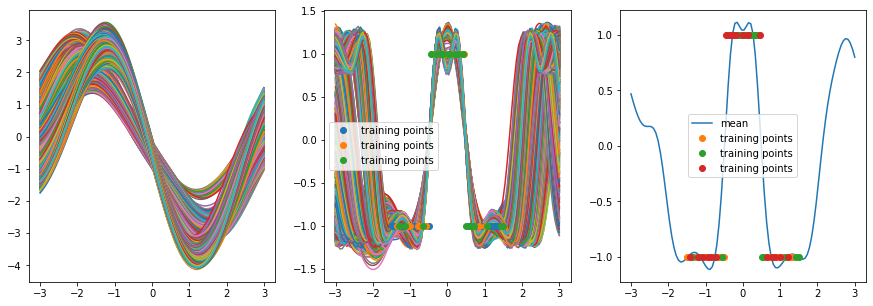

In [39]:
# print sampled lines
fig, ax = plt.subplots(1, model.n_hidden_layers+1, figsize=((model.n_hidden_layers+1)*5, 5))
ax = ax.flatten()
for i in range(model.n_hidden_layers):
    for model_line in lines[::]: # hidden outputs of each sampled model
        line = model_line[i]
        ax[i].plot(X_test[:,0], line.numpy()[:,0])
    # for model_line in lines[690:701]: # hidden outputs of each sampled model
    #     line = model_line[i]
    #     ax[i].plot(X_test.numpy()[:,0], line.numpy()[:,0], 'b')
for x, y in ds_train:
    ax[-2].plot(x[:,0], y[:,0], 'o', label='training points')
# for x, y in ds_test:
    # ax[-1].plot(x[:,0], y[:,0], '*', label='ground truth')
ax[-2].legend()

# compute the mean of the sampled lines
line_output = []
for model_line in lines[::]:
    line_output.append(model_line[-1]) #the final layer
line_mean = tf.reduce_mean(tf.concat(line_output, axis=-1), axis=-1)
ax[-1].plot(X_test[:,0], line_mean.numpy(), label='mean')
for x, y in ds_train:
    ax[-1].plot(x[:,0], y[:,0], 'o', label='training points')
ax[-1].legend()
fig.savefig("2layers-square.png")

index 65, X_test = 0.939393937587738


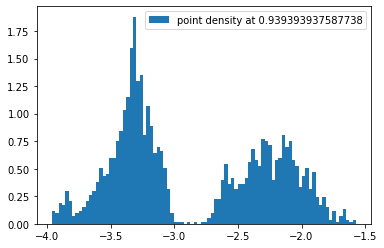

In [40]:
input_index = 65
print(f'index {input_index}, X_test = {X_test[input_index,0]}')
points = []
for model_line in lines[:]:
    line = model_line[0]
    point = line[input_index,0].numpy()
    points.append(point)
fig, ax = plt.subplots(1,1)
ax.hist(points, bins=90, density=True, label=f'point density at {X_test[input_index,0]}')
ax.legend()
fig.savefig('point-3.png')

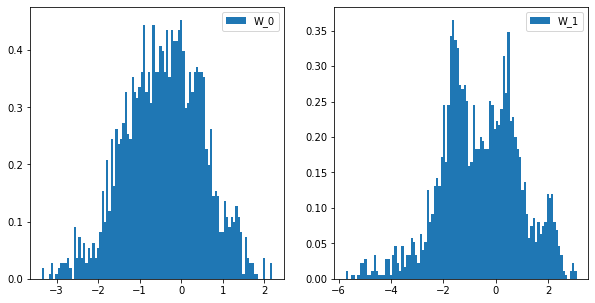

In [68]:
print_index = (69,0)
fig, ax = plt.subplots(1, model.n_hidden_layers, figsize=(model.n_hidden_layers*5,5))
ax = ax.flatten()
for i in range(model.n_hidden_layers):
    W_print = []
    for W_model in W['W_'+str(i)][10:]:
        W_print.append(W_model[print_index])
    ax[i].hist(W_print, bins=100, density=True, label='W_'+str(i))
    ax[i].legend()
# fig.savefig("2w-sq-3.png")

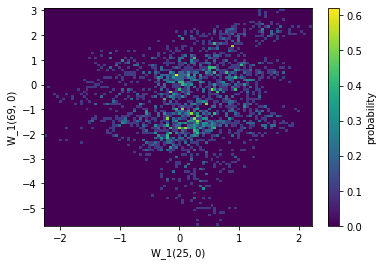

In [75]:
# try to show the correlation of two weights
print_index_1 = (25,0)
print_index_2 = (69,0)
W_print_1 = []
W_print_2 = []
for W_model in W['W_'+ str(1)][20:]:
    W_print_1.append(W_model[print_index_1])
    W_print_2.append(W_model[print_index_2])
plt.hist2d(W_print_1, W_print_2, bins=90, density=True)
plt.xlabel(f'W_1{print_index_1}')
plt.ylabel(f'W_1{print_index_2}')
cbar = plt.colorbar()
cbar.ax.set_ylabel('probability')
# plt.savefig('correlation-sq-2.png')